Get IMFs and predict step ahead of each IMF then summ up and collect y_pred step wise.

Keep lstm as modeling algorithm. Use VMD for decomposition with sensitiity analysis. Search best tf.Generator() train slice length.

Potentially remove NN and leave only LSTM layers for modeling part.

In [1]:
from vmdpy import VMD
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.layers import Conv1D, Dense, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt

class vmd_lstm:

    def train_data(x_train, y_train, length=21):
        '''Train data generator. Can be many steps ahead forecast.
        '''
        data_gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(
            x_train,
            y_train,
            length=length,  # t-n to t
            sampling_rate=1,
            stride=1,  # gap by n-days
            start_index=0,  # ex. start on monday
            end_index=None,
            shuffle=False,
            reverse=False,
            batch_size=256
        )  # missing target length horizon (only manual setting)
        return data_gen
    
    def test_data(x_test, length=21):
        '''Test data should not leak target,
        y_test == np.zeros(len(x_test)).
        '''
        gen_day_ahead = tf.keras.preprocessing.sequence.TimeseriesGenerator(
            x_test,
            np.zeros(len(x_test)),
            length=21,  # t-n to t
            sampling_rate=1,
            stride=1,  # gap by n-days
            start_index=0,  # ex. start on monday
            end_index=None,
            shuffle=False,
            reverse=False,
            batch_size=1
        )  # missing target length horizon (only manual setting)

        return gen_day_ahead
    
    def lstm(input_data, epochs=500, learning_rate=1e-3):
        '''Custom model LSTM-DNN.
        Returns keras.models.Sequential()
        formula and prints log(loss) plot for reference.
        '''
        model = keras.models.Sequential()
        # model.add(keras.layers.Input(shape=(21, 13)))
        # Can have CNN layer if we have many IMFs (test)
        model.add(LSTM(128, return_sequences=True, activation='relu'))
        model.add(LSTM(64, return_sequences=False, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1))

        model.compile(optimizer=Adam(learning_rate=learning_rate), loss=['mse'])
        a = model.fit(input_data, shuffle=False, epochs=epochs, workers=-1, use_multiprocessing=True)
        plt.figure(figsize=(14,8))
        plt.plot(np.log1p(a.history['loss']))
        plt.title("log(Loss history)")
        plt.grid()

        return model
    
    def vmd(input_data, n_modes=13, alpha=200, tol=1e-20, plot=True):
        '''Input data and decompose it to n-modes.
        Function to be used in sensitivity analysis in pre-processing part.
        Returns decomposed_data , y_hat, omega.
        Use plot=False when grid searching for parameters.
        '''
        # Params  
        alpha = alpha  # quadratic penalty, high alpha == bias (sensitivity analysis)
        tau = 0.  # noise-tolerance (no strict fidelity enforcement)  
        K = n_modes  # modes count (sensitivity analysis)
        DC = 0  # no DC part imposed  
        init = 1  # initialize omegas uniformly  
        tol = tol  

        # VMD 
        modes, u_hat, omega = VMD(input_data, alpha, tau, K, DC, init, tol)  

        # Reconstruct data
        a = input_data
        reconstruct = np.sum(pd.DataFrame(modes))  # additive components; shape==(503, 13)
        rmse = np.sqrt(1/len(a) * np.sum(np.square(a-reconstruct)))
        mape = np.mean(np.abs(reconstruct/a-1))
    
        if plot == True:
            # Visualize decomposed modes
            plt.figure(figsize=(14,8))
            plt.subplot(2,1,1)
            plt.plot(input_data)
            plt.title('Original signal')
            plt.subplot(2,1,2)
            plt.plot(modes.T)
            plt.title('Decomposed modes')
            plt.legend(['Mode %d'%m_i for m_i in range(modes.shape[0])])
            plt.tight_layout()

            plt.figure(figsize=(14,8))
            plt.plot(a-reconstruct)
            plt.title("Reconstruction error")
            plt.figure(figsize=(14,8))
            plt.hist(a-reconstruct, bins='fd')

        return modes.T, rmse, mape
    
    def predict_test(x_test, len=21):
        '''x_test = Test data generated 
        from tf.TimeseriesGenerator()
        '''
        offset_length = 100 - len
        y_act = pd.Series(y[-offset_length:])  # uses global y
        y_pred = model.predict(x_test)  # weird format
        y_pred = pd.Series(y_pred.T[0])
        plt.figure(figsize=(32,8))
        plt.plot(y_act, label='actual')
        plt.plot(y_pred, c='r', label='pred')
        plt.legend()
        plt.grid()

        return y_pred, y_act

    def predict_train(x_train, len=21):
        '''x_train = Train data generated 
        from tf.TimeseriesGenerator()
        '''
        offset_length = 1000 - len
        y_act = pd.Series(y[:1000]).shift(-21)
        y_pred = model.predict(data_gen)
        plt.figure(figsize=(32,8))
        plt.plot(y_act, label='actual')
        plt.plot(y_pred, c='r', label='pred')
        plt.legend()
        plt.grid()
        
        return y_pred, y_act

In [3]:
### Pipeline simulation

import yfinance as yf

# Download and prepare financial data
spy_df = yf.download(tickers = "SPY",  # list of tickers
                period = "5y",         # time period
                interval = "1d",       # trading interval
                prepost = False,       # download pre/post market hours data?
                repair = True)
spy_pct = np.log1p(spy_df["Adj Close"].pct_change().dropna())
spy_pct = np.array(spy_pct)

y_total = spy_pct[:-1]

[*********************100%***********************]  1 of 1 completed


In [4]:
%%time
# Gridsearch vmd parameters
# Sensitivity analysis
alphas = list(range(100, 1000, 50))  #range(start,_,_) is really important condition
Ks = list(range(2, 30, 1))  #list(range(2, 50, 1))
print('All combinations:', len(alphas) * len(Ks))

result_collect = []
for i in alphas:
    for j in Ks:
        modes, rmse, mape = vmd_lstm.vmd(y_total, n_modes=j, alpha=i, plot=False)
        result_collect.append([i, j, rmse])

All combinations: 504


KeyboardInterrupt: 

In [19]:
result = pd.DataFrame(result_collect, columns=['alpha', 'K', 'rmse'])
result.nsmallest(5, "rmse")

,alpha,K,rmse
26,100,28,0.000159
27,100,29,0.000159
25,100,27,0.000159
24,100,26,0.000161
22,100,24,0.000163


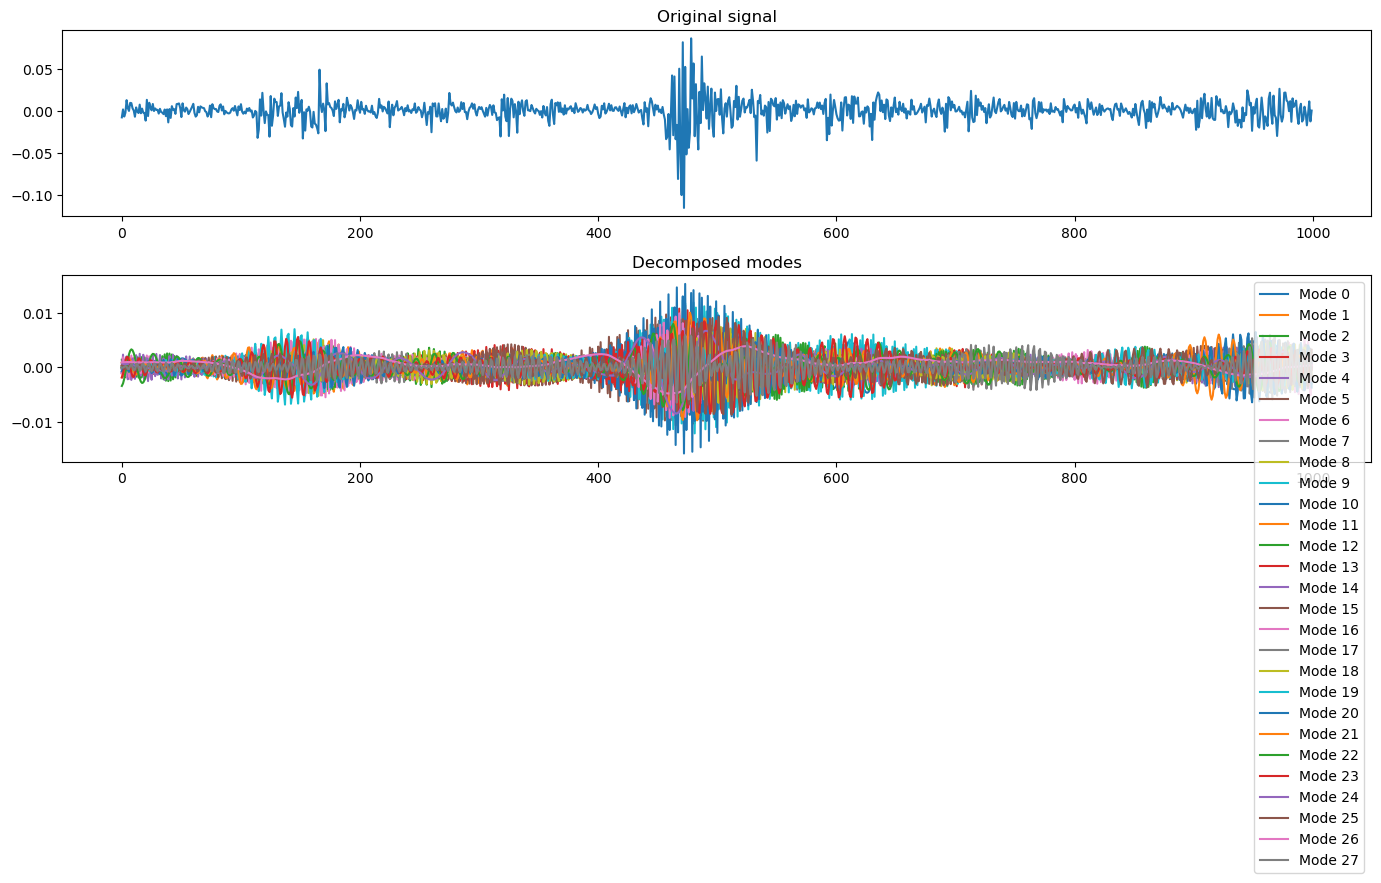

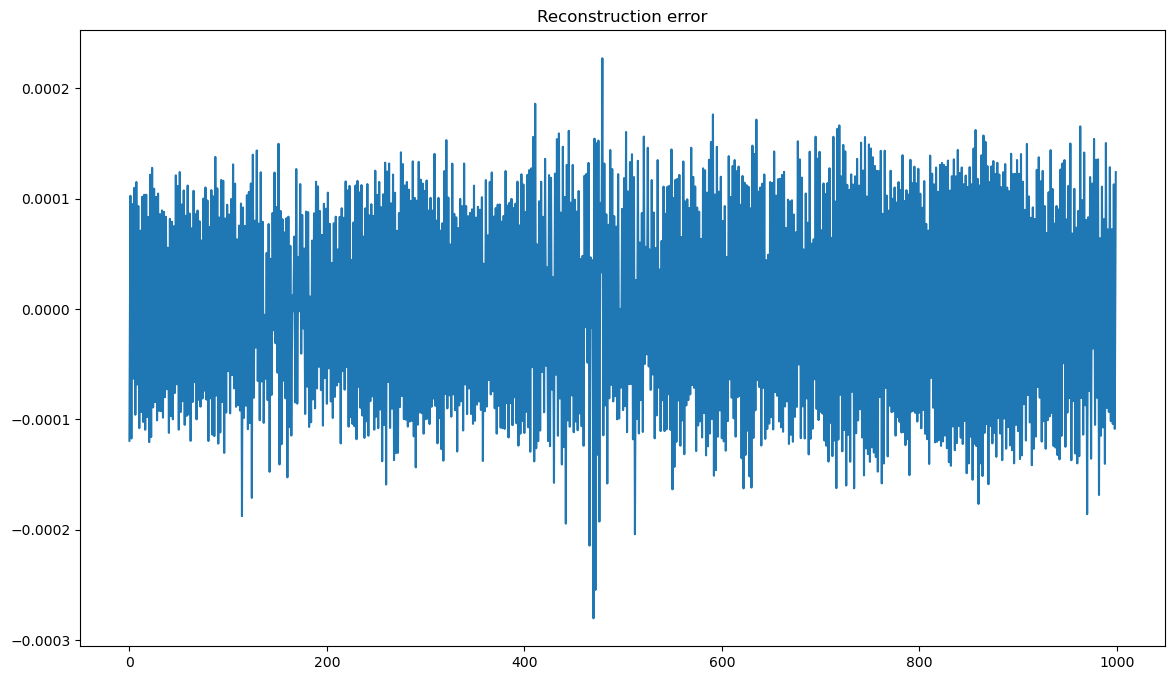

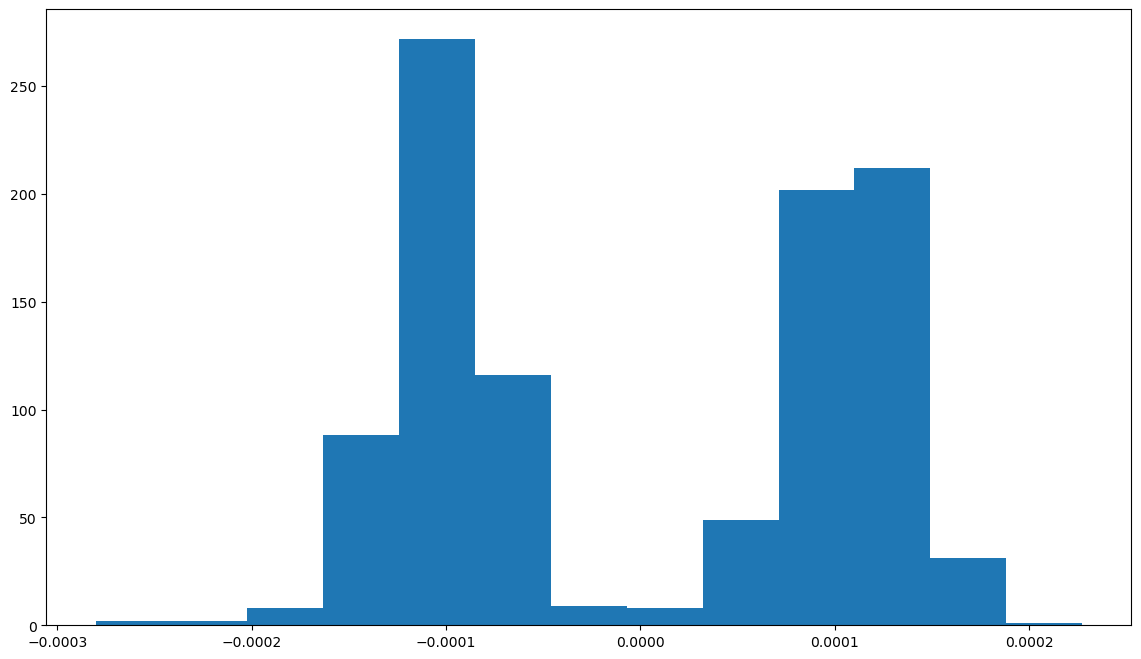

In [17]:
# IMFs input data (vmd param search)
modes, _, _ = vmd_lstm.vmd(y_total[:1000], n_modes=28, alpha=100)

In [ ]:
## Simulator per IMF then sum

index_end = list(range(1000, len(spy_pct), 2))
# index_start = list(range())
i = 0
for i in index_end:
    # Prepare slice for vmd
    y = spy_pct[:i]
    # IMFs input data (vmd param search)
    modes, _, _ = vmd_lstm.vmd(y, n_modes=28, alpha=100)

    imf_count = pd.DataFrame(modes).shape[1]
    collect_pred = []
    # Pred per IMF and collect
    for i in imf_count:
        imf = pd.DataFrame(modes)[i]

        x_train, y_train = imf, imf
        x_test = np.concatenate([imf[-21:], [np.zeros(28)]])
        data_gen = vmd_lstm.train_data(x_train, y_train)
        data_gen_dayahead = vmd_lstm.test_data(x_test)  # don't leak unseen target
        
        # vmd_lstm.lstm(data_gen)